## Importing Dependencies

In [1]:
import tkinter as tk
from tkinter.filedialog import askopenfilename
from PIL import ImageTk, Image
try:
    import pyscreenshot as ImageGrab
except:
    !pip install pyscreenshot
    import pyscreenshot as ImageGrab
    
import numpy as np


#importing custom modules
from ModelUtils import load_model
from ffnn import predict



### Loading model parameters and Preprocessing Image

In [2]:
# Loading the model parameters
def load_parameters():
    path = "Saved Models/"
    file_name = path + "tuned_unscaled_online_Augmented_model_2M_test_acc_0.9916"
    model = load_model(file_name)
    return model["Parameters"]

# Preprocessing the image
def process_image(image):
    #writting the image into global image_data variable
    global image_data
    img = np.asarray(image.convert('L').resize((28,28)))
    if img[1,1] > 250: #if background is white, reversing the fore and background color to match training images
            img = 255 - img
    
    image_flattened = img.reshape(img.shape[0]*img.shape[1],-1)
    image_data =(image_flattened/255.)       


### Drawing on canvas, capturing image and Clearing Canvas

In [3]:
# Drawing on Canvas
def draw_on_canvas(event):
    x = event.x
    y = event.y
    r = 5
    drawCanvas.create_oval( x-r, y-r, x+r, y+r,  fill='black',width = 5)

# Capturing the drawn Image
def capture_canvas_screen():
    #getting the coordinates of the canvas
    root_x = root.winfo_rootx()
    root_y = root.winfo_rooty()
    label_y = inputLbl.winfo_height()
    canvas_x = root_x + drawCanvas.winfo_x()
    canvas_y =  root_y + label_y + drawCanvas.winfo_y()
    canvas_width = drawCanvas.winfo_width()
    canvas_height =  drawCanvas.winfo_height()
   
    #Capturing the image in canvas
    imageDrawn = ImageGrab.grab(bbox=(canvas_x, canvas_y, canvas_x+canvas_width, canvas_y+canvas_height))    
    
    #showing the captured image in preview screen
    preview_image(imageDrawn)
    
    #processing the image before prediction
    process_image(imageDrawn)   



In [4]:
# Clearing the UI
def clear():
    #clearing drawing canvas
    drawCanvas.delete("all")
    
    #clearing image preview
    previewlbl = tk.Label(previewCanvas, text = "Preview Image",font = ("Times",16))
    previewlbl.place(relx = 0, rely = 0, relwidth = 1, relheight = 1 )
    
    #clearing uploaded image name
    fileNamelbl = tk.Label(uploadPane, bg = "green")
    fileNamelbl.place(relx = 0.45, rely = 0.05 , relwidth = 0.5, relheight = 0.08 )
    
    #clearing prediction window
    firstPredLbl = tk.Label(firstPredictionPane)
    firstPredLbl.place(relx = 0, rely = 0, relwidth = 1, relheight = 0.6 )

    firstPredProb = tk.Label(firstPredictionPane)
    firstPredProb.place(relx = 0, rely = 0.6, relwidth = 1, relheight = 0.4 )

    fsecondPredLbl = tk.Label(secondPredictionPane)
    fsecondPredLbl.place(relx = 0, rely = 0, relwidth = 1, relheight = 0.6 )

    fsecondPredProb = tk.Label(secondPredictionPane)
    fsecondPredProb.place(relx = 0, rely = 0.6, relwidth = 1, relheight = 0.4 )

    #clearing image data
    global image_data
    image_data = np.zeros((784,1))
    

### Uploading Image from Local Storage

In [5]:
def upload_image():
    filepath = askopenfilename() # show an "Open" dialog box and return the path to the selected file
    #extracting the file name from the file path and displaying it
    filename = filepath.split("/")[-1]
    
    #extracting the extension of the file
    ext = filename.split(".")[-1]
    possible_ext = ["jpg","png","jpeg"] #allowed image extensions
    
    fileNamelbl = tk.Label(uploadPane, text = filename, bg = "white",font = ("Times",10))
    fileNamelbl.place(relx = 0.45, rely = 0.05 , relwidth = 0.5, relheight = 0.08 )

    if ext.lower() in possible_ext:
        imageUpload = Image.open(filepath) 
        
        #showing the uploaded image in preview screen
        preview_image(imageUpload)

        #processing the image before prediction
        process_image(imageUpload)
    else:
        msz = "Preview not available!\n\n Cause: Unsupported File Type.\n\nSolution: Upload an image with\n.jpg, .png or .jpeg extension"
        previewlbl = tk.Label(previewCanvas, text = msz,  font = ("Times",16))
        previewlbl.place(relx = 0, rely = 0, relwidth = 1, relheight = 1 )

### Previewing Uploaded or Drawn Image

In [6]:
def preview_image(image):
    #rendering the preview of image in the Preview Pane
    image = image.resize((300, 300), Image.ANTIALIAS)
    imageRender = ImageTk.PhotoImage(image)
    img = tk.Label(previewCanvas, image=imageRender)
    img.image = imageRender
    img.place(relx = 0, rely = 0, relwidth = 1, relheight = 1 )

### Predicting the image Class

In [7]:
def classify():
#     root.after(100,capture_canvas_screen)
    # Pridicting only of image is drawn or uploaded
    if not np.equal(image_data, np.zeros((784,1))).all():
    
        prediction = predict(image_data, params, second_guess = True)

        first_lbl, first_prob = prediction["First Prediction"]
        sec_lbl, sec_prob = prediction["Second Prediction"]

        firstPredLbl = tk.Label(firstPredictionPane, text = first_lbl.squeeze(), font = ("Times",40))
        firstPredLbl.place(relx = 0, rely = 0, relwidth = 1, relheight = 0.6 )

        firstPredProb = tk.Label(firstPredictionPane, text = "Confidence: %.4f%%"%(first_prob.squeeze()*100), font = ("Times",16))
        firstPredProb.place(relx = 0, rely = 0.6, relwidth = 1, relheight = 0.4 )

        fsecondPredLbl = tk.Label(secondPredictionPane, text = "Second Guess: \n%d"%(sec_lbl.squeeze()), font = ("Times",32))
        fsecondPredLbl.place(relx = 0, rely = 0, relwidth = 1, relheight = 0.6 )

        fsecondPredProb = tk.Label(secondPredictionPane, text = "Confidence: %.4f%%"%(sec_prob.squeeze()*100), font = ("Times",16))
        fsecondPredProb.place(relx = 0, rely = 0.6, relwidth = 1, relheight = 0.4 )
    
    else:
        firstPredLbl = tk.Label(firstPredictionPane, text = "Draw on the canvas \nand capture", font = ("Times",16))
        firstPredLbl.place(relx = 0, rely = 0, relwidth = 1, relheight = 1 )
       
        fsecondPredLbl = tk.Label(secondPredictionPane, text = "Or Upload \nan image of a digit", font = ("Times",16))
        fsecondPredLbl.place(relx = 0, rely = 0, relwidth = 1, relheight = 1 )


### GUI Application Interface

In [8]:

global image_data
root = tk.Tk()
root.title("Handwritten Digit Recognizer")
HEIGHT = 800
WIDTH = 800
image_data = np.zeros((784,1))


#preloading the trained model's parameters
params = load_parameters()

root.geometry(str(WIDTH) + "x" + str(HEIGHT) )
root.resizable(width=False, height=False)

#creating Frames
imageFrame = tk.Frame(root, bg = "red") #contains ways to input image
actionFrame = tk.Frame(root, bg = "blue") # contains options for result and buttons for action
predictionFrame = tk.Frame(root, bg = "white") # consists of result of the prediction

imageFrame.place(relx=0  ,rely=0 ,relwidth = 1, relheight = 0.6)
actionFrame.place(relx=0  ,rely=0.6 ,relwidth = 1, relheight = 0.1)
predictionFrame.place(relx =0 , rely =0.7 , relwidth = 1, relheight = 0.3)

#Image Frame
##Input image label
inputLbl = tk.Label(imageFrame, text="Input Image", font=("Helvetica", 24))
inputLbl.place(relx = 0, rely = 0, relwidth = 1, relheight = 0.1 )

##Creating Panes for Image Input
drawPane = tk.PanedWindow(imageFrame,bg = "green" )
uploadPane = tk.PanedWindow(imageFrame,bg = "green" )

drawPane.place(relx = 0, rely = 0.1, relwidth = 0.5, relheight = 0.9)
uploadPane.place(relx = 0.5, rely = 0.1, relwidth = 0.5, relheight = 0.9)

###drawPane
#creating components for drawPane
captureBtn = tk.Button(drawPane, text = "Capture Drawing",font = ("Times",10), command = capture_canvas_screen )
drawCanvas = tk.Canvas(drawPane,bg = "white", cursor="cross")

captureBtn.place(relx = 0.05, rely = 0.05, relwidth = 0.4, relheight = 0.08 )
drawCanvas.place(relx = 0.05, rely = 0.15, relwidth = 0.9, relheight = 0.8 )
drawCanvas.bind("<B1-Motion>", draw_on_canvas)


###uploadPane
uploadBtn = tk.Button(uploadPane, text = "Upload Image", font = ("Times",10), command = upload_image )
previewCanvas = tk.Canvas(uploadPane, bg = "white")
previewlbl = tk.Label(previewCanvas, text = "Image Preview",font = ("Times",16))

uploadBtn.place(relx = 0.05, rely = 0.05 , relwidth = 0.4, relheight = 0.08 )
previewCanvas.place(relx = 0.05, rely = 0.15, relwidth =0.9, relheight = 0.8 )
previewlbl.place(relx = 0, rely = 0, relwidth = 1, relheight = 1 )

#Action Frame
buttonPane = tk.PanedWindow(actionFrame,bg = "ivory4" )
buttonPane.place(relx = 0, rely = 0, relwidth = 1, relheight = 1)

## buttonPane
classifyBtn = tk.Button(buttonPane,text = "Predict", font = ("Times",16), command = classify)
button_clear = tk.Button(buttonPane, text = "Clear", font = ("Times",16), command = clear)

classifyBtn.place(relx = 0.05, rely = 0.1, relwidth = 0.4, relheight = 0.8 )
button_clear.place(relx = 0.55, rely = 0.1, relwidth = 0.4, relheight = 0.8)


#Prediction Frame
##Prediction Labels
predictLbl = tk.Label(predictionFrame, text="Prediction", font=("Times", 24))
predictLbl.place(relx = 0, rely = 0, relwidth = 1, relheight = 0.2 )

##Prediction Panes
firstPredictionPane = tk.PanedWindow(predictionFrame, bg = "green")
secondPredictionPane = tk.PanedWindow(predictionFrame, bg = "green")

firstPredictionPane.place(relx = 0, rely = 0.2, relwidth = 0.5, relheight = 0.8)
secondPredictionPane.place(relx = 0.5, rely = 0.2, relwidth = 0.5, relheight = 0.8)

###First Prediction Pane
firstPredLbl = tk.Label(firstPredictionPane)
firstPredLbl.place(relx = 0, rely = 0, relwidth = 1, relheight = 0.6 )

firstPredProb = tk.Label(firstPredictionPane)
firstPredProb.place(relx = 0, rely = 0.6, relwidth = 1, relheight = 0.4 )

###Second Prediction Pane
fsecondPredLbl = tk.Label(secondPredictionPane)
fsecondPredLbl.place(relx = 0, rely = 0, relwidth = 1, relheight = 0.6 )

fsecondPredProb = tk.Label(secondPredictionPane)
fsecondPredProb.place(relx = 0, rely = 0.6, relwidth = 1, relheight = 0.4 )

root.mainloop()


(0.0, 9.0)

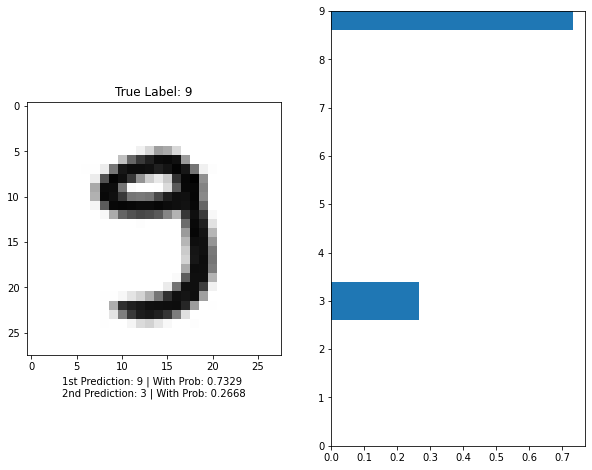

In [22]:
import matplotlib.pyplot as plt
#experimenting
digit = 9
image_name = str(digit)+"_1.jpg" 
label = np.array([digit]).reshape(1,1)

fname = "Sample Images/" + image_name

# def classify_image(fname):
image_data = 255 - np.asarray(Image.open(fname).convert('L').resize((28,28)))
image_flattened = image_data.reshape(image_data.shape[0]*image_data.shape[1],-1)
image_norm =(image_flattened/255.)


prediction = predict(image_norm,params,second_guess = True)


# prediction  = classify_image(fname)
first_lbl, first_prob = prediction["First Prediction"]
sec_lbl, sec_prob = prediction["Second Prediction"]

fig,ax = plt.subplots(nrows =1 , ncols =2 , figsize = (10,8))
fig.subplots_adjust(hspace=0)

ax[0].set_title("True Label: "+ str(label.squeeze()))
ax[0].set_xlabel("1st Prediction: %d | With Prob: %.4f \n2nd Prediction: %d | With Prob: %.4f"%(first_lbl, first_prob, sec_lbl, sec_prob))
im = ax[0].imshow(image_data, interpolation ='nearest',cmap='binary')

# fig.colorbar(im)
ax[1].barh([first_lbl.squeeze(),sec_lbl.squeeze() ],[first_prob.squeeze(),sec_prob.squeeze()])
ax[1].set_ylim(bottom = 0, top = 9)